<a href="https://colab.research.google.com/github/francescopatane96/Bioactivity-prediction-with-ML/blob/main/Copia_di_ML7upfin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install rdkit

In [ ]:
!pip install lazypredict

In [3]:
!pip install git+https://github.com/volkamerlab/teachopencadd.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/volkamerlab/teachopencadd.git to /tmp/pip-req-build-m7gu1i4y
  Running command git clone -q https://github.com/volkamerlab/teachopencadd.git /tmp/pip-req-build-m7gu1i4y
  Created wheel for teachopencadd: filename=teachopencadd-2022.9.0+2.g8f2c87a-py3-none-any.whl size=108231919 sha256=6ad674f9867e73e539660d5fd38c19b6032cd9392a7c5545038dd2c79d8ba620
  Stored in directory: /tmp/pip-ephem-wheel-cache-3gkyv1r2/wheels/ee/da/82/b2c07c8ddbf7e09a56a283a394ebff26d956480b85a9ef011f
Successfully built teachopencadd


In [4]:
from pathlib import Path
import seaborn as sns
from warnings import filterwarnings
import time
import lazypredict
from lazypredict.Supervised import LazyRegressor
from lazypredict.Supervised import LazyClassifier

import pandas as pd
import numpy as np
from sklearn import svm, metrics, clone
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import auc, accuracy_score, recall_score
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import MACCSkeys
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect

from teachopencadd.utils import seed_everything

# Silence some expected warnings
filterwarnings("ignore")
# Fix seed for reproducible results
SEED = 22
seed_everything(SEED)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [5]:
# Read data (Lipinski)
chembl_df = pd.read_csv(
    "IDH_compounds_lipinski.csv",
    index_col=0,
)

# Look at head
print("Shape of dataframe : ", chembl_df.shape)
chembl_df.head()


Shape of dataframe :  (1545, 11)


,molecule_chembl_id,IC50,units,smiles,pIC50,ROMol,molecular_weight,n_hba,n_hbd,logp,ro5_fulfilled
0,CHEMBL4279047,0.04,nM,C[C@@H](Nc1nc(N[C@H](C)C(F)(F)F)nc(-c2cccc(Cl)...,10.40,"<img data-content=""rdkit/molecule"" src=""data:i...",414.08,6,2,4.31,True
1,CHEMBL4278845,0.25,nM,C[C@H](Nc1nc(N[C@@H](C)C(F)(F)F)nc(-c2cccc(Cl)...,9.60,"<img data-content=""rdkit/molecule"" src=""data:i...",414.08,6,2,4.31,True
2,CHEMBL4283785,0.30,nM,CC(Nc1nc(NC(C)C(F)(F)F)nc(-c2cccc(Cl)n2)n1)C(F...,9.52,"<img data-content=""rdkit/molecule"" src=""data:i...",414.08,6,2,4.31,True
3,CHEMBL4280132,0.70,nM,FC1(F)CCC(Nc2nc(NC3CCC(F)(F)C3)nc(-c3cccc(Cl)n...,9.15,"<img data-content=""rdkit/molecule"" src=""data:i...",430.13,6,2,4.79,True
4,CHEMBL3909586,1.00,nM,C[C@H](Nc1nccc(N2C(=O)OC[C@@H]2[C@H](C)F)n1)c1...,9.00,"<img data-content=""rdkit/molecule"" src=""data:i...",446.17,7,1,4.46,True


In [6]:
# Feature for proving and Proving our data \\ NaN finder
def check_missing_values(dataframe):
    
    if dataframe.isnull().sum().sum() > 0:
        m_total = dataframe.isnull().sum().sort_values(ascending=False) 
        total = m_total[m_total > 0]

        m_percent = dataframe.isnull().mean().sort_values(ascending=False) 
        percent = m_percent[m_percent > 0] 

        missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    
        print(f'Total and Percentage of NaN:\n {missing_data}')
    else: 
        print('No NaN found.')
        
        
check_missing_values(dataframe=chembl_df)

No NaN found.


In [7]:
# remove NaN
chembl_df = chembl_df.dropna()

In [9]:
chembl_df.shape

(1545, 11)

In [10]:
# Keep only the columns we want
chembl_df = chembl_df[["molecule_chembl_id", "smiles", "pIC50"]]
chembl_df.head()


,molecule_chembl_id,smiles,pIC50
0,CHEMBL4279047,C[C@@H](Nc1nc(N[C@H](C)C(F)(F)F)nc(-c2cccc(Cl)...,10.40
1,CHEMBL4278845,C[C@H](Nc1nc(N[C@@H](C)C(F)(F)F)nc(-c2cccc(Cl)...,9.60
2,CHEMBL4283785,CC(Nc1nc(NC(C)C(F)(F)F)nc(-c2cccc(Cl)n2)n1)C(F...,9.52
3,CHEMBL4280132,FC1(F)CCC(Nc2nc(NC3CCC(F)(F)C3)nc(-c3cccc(Cl)n...,9.15
4,CHEMBL3909586,C[C@H](Nc1nccc(N2C(=O)OC[C@@H]2[C@H](C)F)n1)c1...,9.00


In [11]:
# Add column for activity
chembl_df["active"] = np.zeros(len(chembl_df))

# Mark every molecule as active with an pIC50 of >= 6.3, 0 otherwise
chembl_df.loc[chembl_df[chembl_df.pIC50 >= 6.3].index, "active"] = 1.0

# NBVAL_CHECK_OUTPUT
print("Number of active compounds:", int(chembl_df.active.sum()))
print("Number of inactive compounds:", len(chembl_df) - int(chembl_df.active.sum()))

Number of active compounds: 978
Number of inactive compounds: 567


In [12]:
chembl_df.head()


,molecule_chembl_id,smiles,pIC50,active
0,CHEMBL4279047,C[C@@H](Nc1nc(N[C@H](C)C(F)(F)F)nc(-c2cccc(Cl)...,10.40,1.00
1,CHEMBL4278845,C[C@H](Nc1nc(N[C@@H](C)C(F)(F)F)nc(-c2cccc(Cl)...,9.60,1.00
2,CHEMBL4283785,CC(Nc1nc(NC(C)C(F)(F)F)nc(-c2cccc(Cl)n2)n1)C(F...,9.52,1.00
3,CHEMBL4280132,FC1(F)CCC(Nc2nc(NC3CCC(F)(F)C3)nc(-c3cccc(Cl)n...,9.15,1.00
4,CHEMBL3909586,C[C@H](Nc1nccc(N2C(=O)OC[C@@H]2[C@H](C)F)n1)c1...,9.00,1.00


In [13]:
def smiles_to_fp(smiles, method="maccs", n_bits=2048):
    """
    Encode a molecule from a SMILES string into a fingerprint.

    Parameters
    ----------
    smiles : str
        The SMILES string defining the molecule.

    method : str
        The type of fingerprint to use. Default is MACCS keys.

    n_bits : int
        The length of the fingerprint.

    Returns
    -------
    array
        The fingerprint array.

    """

    # convert smiles to RDKit mol object
    mol = Chem.MolFromSmiles(smiles)

    if method == "maccs":
        return np.array(MACCSkeys.GenMACCSKeys(mol))
    if method == "morgan2":
        return np.array(GetMorganFingerprintAsBitVect(mol, 2, nBits=n_bits))
    if method == "morgan3":
        return np.array(GetMorganFingerprintAsBitVect(mol, 3, nBits=n_bits))
    else:
        # NBVAL_CHECK_OUTPUT
        print(f"Warning: Wrong method specified: {method}. Default will be used instead.")
        return np.array(MACCSkeys.GenMACCSKeys(mol))

In [14]:
# Add column for fingerprint
chembl_df["fp"] = chembl_df["smiles"].apply(smiles_to_fp)
chembl_df.head(3)
# NBVAL_CHECK_OUTPUT

,molecule_chembl_id,smiles,pIC50,active,fp
0,CHEMBL4279047,C[C@@H](Nc1nc(N[C@H](C)C(F)(F)F)nc(-c2cccc(Cl)...,10.40,1.00,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,CHEMBL4278845,C[C@H](Nc1nc(N[C@@H](C)C(F)(F)F)nc(-c2cccc(Cl)...,9.60,1.00,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,CHEMBL4283785,CC(Nc1nc(NC(C)C(F)(F)F)nc(-c2cccc(Cl)n2)n1)C(F...,9.52,1.00,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [15]:
def plot_roc_curves_for_models(models, test_x, test_y, save_png=False):
    """
    Helper function to plot customized roc curve.

    Parameters
    ----------
    models: dict
        Dictionary of pretrained machine learning models.
    test_x: list
        Molecular fingerprints for test set.
    test_y: list
        Associated activity labels for test set.
    save_png: bool
        Save image to disk (default = False)

    Returns
    -------
    fig:
        Figure.
    """

    fig, ax = plt.subplots()

    # Below for loop iterates through your models list
    for model in models:
        # Select the model
        ml_model = model["model"]
        # Prediction probability on test set
        test_prob = ml_model.predict_proba(test_x)[:, 1]
        # Prediction class on test set
        test_pred = ml_model.predict(test_x)
        # Compute False postive rate and True positive rate
        fpr, tpr, thresholds = metrics.roc_curve(test_y, test_prob)
        # Calculate Area under the curve to display on the plot
        auc = roc_auc_score(test_y, test_prob)
        # Plot the computed values
        ax.plot(fpr, tpr, label=(f"{model['label']} AUC area = {auc:.2f}"))

    # Custom settings for the plot
    ax.plot([0, 1], [0, 1], "r--")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("Receiver Operating Characteristic")
    ax.legend(loc="lower right")
    # Save plot
    if save_png:
        fig.savefig(f"{DATA}/roc_auc", dpi=300, bbox_inches="tight", transparent=True)
    return fig

In [16]:
def model_performance(ml_model, test_x, test_y, verbose=True):
    """
    Helper function to calculate model performance

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    test_x: list
        Molecular fingerprints for test set.
    test_y: list
        Associated activity labels for test set.
    verbose: bool
        Print performance measure (default = True)

    Returns
    -------
    tuple:
        Accuracy, sensitivity, specificity, auc on test set.
    """

    # Prediction probability on test set
    test_prob = ml_model.predict_proba(test_x)[:, 1]

    # Prediction class on test set
    test_pred = ml_model.predict(test_x)

    # Performance of model on test set
    accuracy = accuracy_score(test_y, test_pred)
    sens = recall_score(test_y, test_pred)
    spec = recall_score(test_y, test_pred, pos_label=0)
    auc = roc_auc_score(test_y, test_prob)

    if verbose:
        # Print performance results
        # NBVAL_CHECK_OUTPUT        print(f"Accuracy: {accuracy:.2}")
        print(f"Sensitivity: {sens:.2f}")
        print(f"Specificity: {spec:.2f}")
        print(f"AUC: {auc:.2f}")

    return accuracy, sens, spec, auc

In [17]:
def model_training_and_validation(ml_model, name, splits, verbose=True):
    """
    Fit a machine learning model on a random train-test split of the data
    and return the performance measures.

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    name: str
        Name of machine learning algorithm: RF, SVM, ANN
    splits: list
        List of desciptor and label data: train_x, test_x, train_y, test_y.
    verbose: bool
        Print performance info (default = True)

    Returns
    -------
    tuple:
        Accuracy, sensitivity, specificity, auc on test set.

    """
    train_x, test_x, train_y, test_y = splits

    # Fit the model
    ml_model.fit(train_x, train_y)

    # Calculate model performance results
    accuracy, sens, spec, auc = model_performance(ml_model, test_x, test_y, verbose)

    return accuracy, sens, spec, auc

In [18]:
fingerprint_to_model = chembl_df.fp.tolist()
label_to_model = chembl_df.active.tolist()

# Split data randomly in train and test set
# note that we use test/train_x for the respective fingerprint splits
# and test/train_y for the respective label splits
(
    static_train_x,
    static_test_x,
    static_train_y,
    static_test_y,
) = train_test_split(fingerprint_to_model, label_to_model, test_size=0.2, random_state=SEED)
splits = [static_train_x, static_test_x, static_train_y, static_test_y]
# NBVAL_CHECK_OUTPUT
print("Training data size:", len(static_train_x))
print("Test data size:", len(static_test_x))

Training data size: 1236
Test data size: 309


In [29]:
# Set model parameter for random forest
param = {
    "n_estimators": 200,  # number of trees to grows
    "criterion": "entropy",  # cost function to be optimized for a split
}
model_RF = RandomForestClassifier(**param)

In [34]:
# Fit model on single split
performance_measures = model_training_and_validation(model_RF, "RF", splits)

Sensitivity: 0.79
Specificity: 0.74
AUC: 0.86


In [37]:
r2_RF = model_RF.score(static_test_x, static_test_y)
r2_RF

0.7734627831715211

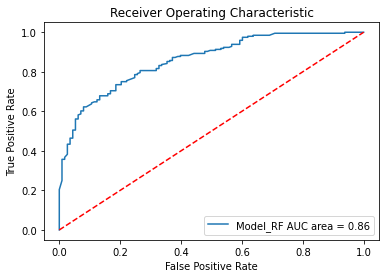

In [38]:
# Initialize the list that stores all models. First one is RF.
models = [{"label": "Model_RF", "model": model_RF}]
# Plot roc curve
plot_roc_curves_for_models(models, static_test_x, static_test_y);

In [40]:
# Specify model
model_SVM = svm.SVC(kernel="rbf", C=1, gamma=0.1, probability=True)

# Fit model on single split
performance_measures = model_training_and_validation(model_SVM, "SVM", splits)

Sensitivity: 0.83
Specificity: 0.69
AUC: 0.83


In [54]:
r2_SVM = model_SVM.score(static_test_x, static_test_y)
r2_SVM

0.7799352750809061

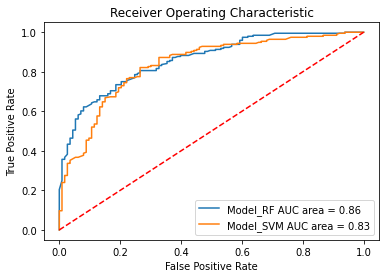

In [41]:
# Append SVM model
models.append({"label": "Model_SVM", "model": model_SVM})
# Plot roc curve
plot_roc_curves_for_models(models, static_test_x, static_test_y);

In [42]:
# Specify model
model_ANN = MLPClassifier(hidden_layer_sizes=(5, 3), random_state=SEED)

# Fit model on single split
performance_measures = model_training_and_validation(model_ANN, "ANN", splits)

Sensitivity: 0.83
Specificity: 0.64
AUC: 0.83


In [55]:
r2_ANN = model_ANN.score(static_test_x, static_test_y)
r2_ANN

0.7605177993527508

NameError: ignored

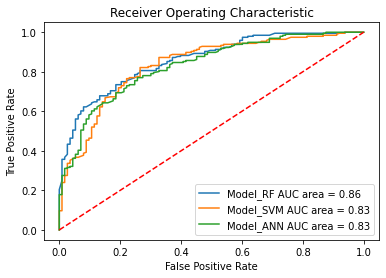

In [43]:
# Append ANN model
models.append({"label": "Model_ANN", "model": model_ANN})
# Plot roc curve
plot_roc_curves_for_models(models, static_test_x, static_test_y, True)

In [44]:
def crossvalidation(ml_model, df, n_folds=5, verbose=False):
    """
    Machine learning model training and validation in a cross-validation loop.

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    df: pd.DataFrame
        Data set with SMILES and their associated activity labels.
    n_folds: int, optional
        Number of folds for cross-validation.
    verbose: bool, optional
        Performance measures are printed.

    Returns
    -------
    None

    """
    t0 = time.time()
    # Shuffle the indices for the k-fold cross-validation
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=SEED)

    # Results for each of the cross-validation folds
    acc_per_fold = []
    sens_per_fold = []
    spec_per_fold = []
    auc_per_fold = []

    # Loop over the folds
    for train_index, test_index in kf.split(df):
        # clone model -- we want a fresh copy per fold!
        fold_model = clone(ml_model)
        # Training

        # Convert the fingerprint and the label to a list
        train_x = df.iloc[train_index].fp.tolist()
        train_y = df.iloc[train_index].active.tolist()

        # Fit the model
        fold_model.fit(train_x, train_y)

        # Testing

        # Convert the fingerprint and the label to a list
        test_x = df.iloc[test_index].fp.tolist()
        test_y = df.iloc[test_index].active.tolist()

        # Performance for each fold
        accuracy, sens, spec, auc = model_performance(fold_model, test_x, test_y, verbose)

        # Save results
        acc_per_fold.append(accuracy)
        sens_per_fold.append(sens)
        spec_per_fold.append(spec)
        auc_per_fold.append(auc)

    # Print statistics of results
    print(
        f"Mean accuracy: {np.mean(acc_per_fold):.2f} \t"
        f"and std : {np.std(acc_per_fold):.2f} \n"
        f"Mean sensitivity: {np.mean(sens_per_fold):.2f} \t"
        f"and std : {np.std(sens_per_fold):.2f} \n"
        f"Mean specificity: {np.mean(spec_per_fold):.2f} \t"
        f"and std : {np.std(spec_per_fold):.2f} \n"
        f"Mean AUC: {np.mean(auc_per_fold):.2f} \t"
        f"and std : {np.std(auc_per_fold):.2f} \n"
        f"Time taken : {time.time() - t0:.2f}s\n"
    )

    return acc_per_fold, sens_per_fold, spec_per_fold, auc_per_fold

In [47]:
N_FOLDS = 10

In [48]:
for model in models:
    print("\n======= ")
    print(f"{model['label']}")
    crossvalidation(model["model"], chembl_df, n_folds=N_FOLDS)


Model_RF
Mean accuracy: 0.77 	and std : 0.03 
Mean sensitivity: 0.83 	and std : 0.04 
Mean specificity: 0.67 	and std : 0.07 
Mean AUC: 0.84 	and std : 0.03 
Time taken : 4.76s


Model_SVM
Mean accuracy: 0.78 	and std : 0.04 
Mean sensitivity: 0.87 	and std : 0.05 
Mean specificity: 0.62 	and std : 0.08 
Mean AUC: 0.85 	and std : 0.03 
Time taken : 11.57s


Model_ANN
Mean accuracy: 0.77 	and std : 0.03 
Mean sensitivity: 0.86 	and std : 0.04 
Mean specificity: 0.60 	and std : 0.06 
Mean AUC: 0.84 	and std : 0.03 
Time taken : 8.67s



In [49]:
# Reset data frame
compound_df = chembl_df.copy()

In [50]:
# Use Morgan fingerprint with radius 3
compound_df["fp"] = compound_df["smiles"].apply(smiles_to_fp, args=("morgan3",))
compound_df.head(3)
# NBVAL_CHECK_OUTPUT

,molecule_chembl_id,smiles,pIC50,active,fp
0,CHEMBL4279047,C[C@@H](Nc1nc(N[C@H](C)C(F)(F)F)nc(-c2cccc(Cl)...,10.40,1.00,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,CHEMBL4278845,C[C@H](Nc1nc(N[C@@H](C)C(F)(F)F)nc(-c2cccc(Cl)...,9.60,1.00,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,CHEMBL4283785,CC(Nc1nc(NC(C)C(F)(F)F)nc(-c2cccc(Cl)n2)n1)C(F...,9.52,1.00,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
for model in models:
    if model["label"] == "Model_SVM":
        # SVM is super slow with long fingerprints
        # and will have a performance similar to RF
        # We can skip it in this test, but if you want
        # to run it, feel free to replace `continue` with `pass`
        continue
    print("\n=======")
    print(model["label"])
    crossvalidation(model["model"], compound_df, n_folds=N_FOLDS)

Novel drugs prediction

In [84]:
smis = ["CN2C(=O)N(C)C(=O)C1=C2N=CN1C"]

cans = [Chem.MolToSmiles(Chem.MolFromSmiles(smi),True) for smi in smis]


In [85]:
df = pd.DataFrame({'smile': ['CN2C(=O)N(C)C(=O)C1=C2N=CN1C']
                   })

AttributeError: ignored

In [77]:
df.to_csv('drugs.csv')

In [86]:
pred = model_RF.predict([df])
print("pIC50 prediction", pred)

ValueError: ignored

In [87]:
drugs = pd.read_csv('drugs.csv')
pred = model_RF.predict([drugs])
print("pIC50 prediction", pred)

ValueError: ignored

generate model as Pickle Object

In [88]:
import pickle

In [89]:
pickle.dump(model_RF, open('IDH_model.pkl', 'wb'))